In [ ]:
#import libraries
import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import os
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#loading the dataset and assigning the respective label for each image
#since the image is divided into stroke or normal, each image has a corresponding label of stroke or normal
path = '/content/drive/MyDrive/Brain_Data_Organised/*'
images = []
labels = []
i = 0
for folder in glob.glob(path):
    for filename in os.listdir(os.path.join(path,folder)):
        img = cv2.imread(os.path.join(path,folder,filename))
        img = cv2.resize(img,(256,256),interpolation = cv2.INTER_AREA)
        if img is not None:
            images.append(img)
            labels.append(folder.split('/')[-1])
        else:
            i = 0
            break

In [ ]:
labels[0:10] #showing the labels of the first 10 labels 

['Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal']

In [ ]:
images = np.array(images) #convert the images and labels into arrays for easier computations
labels_a = np.array(labels)
print(len(images))
print(len(labels))

2501
2501


In [ ]:
#now we encode the labels as 0's or 1's, 0 will be assigned to Normal, and 1 will be assigned to stroke.
labelencoder = LabelEncoder()
labels_a = labelencoder.fit_transform(labels_a)

In [ ]:
multipleImagesNormal = glob.glob('/content/drive/MyDrive/Brain_Data_Organised/Normal/*')
multipleImagesStroke = glob.glob('/content/drive/MyDrive/Brain_Data_Organised/Stroke/*')
def plotImages2():
    r = random.sample(multipleImagesNormal, 4)
    s = random.sample(multipleImagesStroke, 4)
    plt.figure(figsize=(20,20))
    plt.subplot(421)
    plt.imshow(cv2.imread(r[0])); plt.axis('off')
    plt.subplot(422)
    plt.imshow(cv2.imread(r[1])); plt.axis('off')
    plt.subplot(423)
    plt.imshow(cv2.imread(r[2])); plt.axis('off')
    plt.subplot(424)
    plt.imshow(cv2.imread(r[3])); plt.axis('off')
    plt.subplot(425)
    plt.imshow(cv2.imread(s[0])); plt.axis('off')
    plt.subplot(426)
    plt.imshow(cv2.imread(s[1])); plt.axis('off')
    plt.subplot(427)
    plt.imshow(cv2.imread(s[2])); plt.axis('off')
    plt.subplot(428)
    plt.imshow(cv2.imread(s[3])); plt.axis('off')

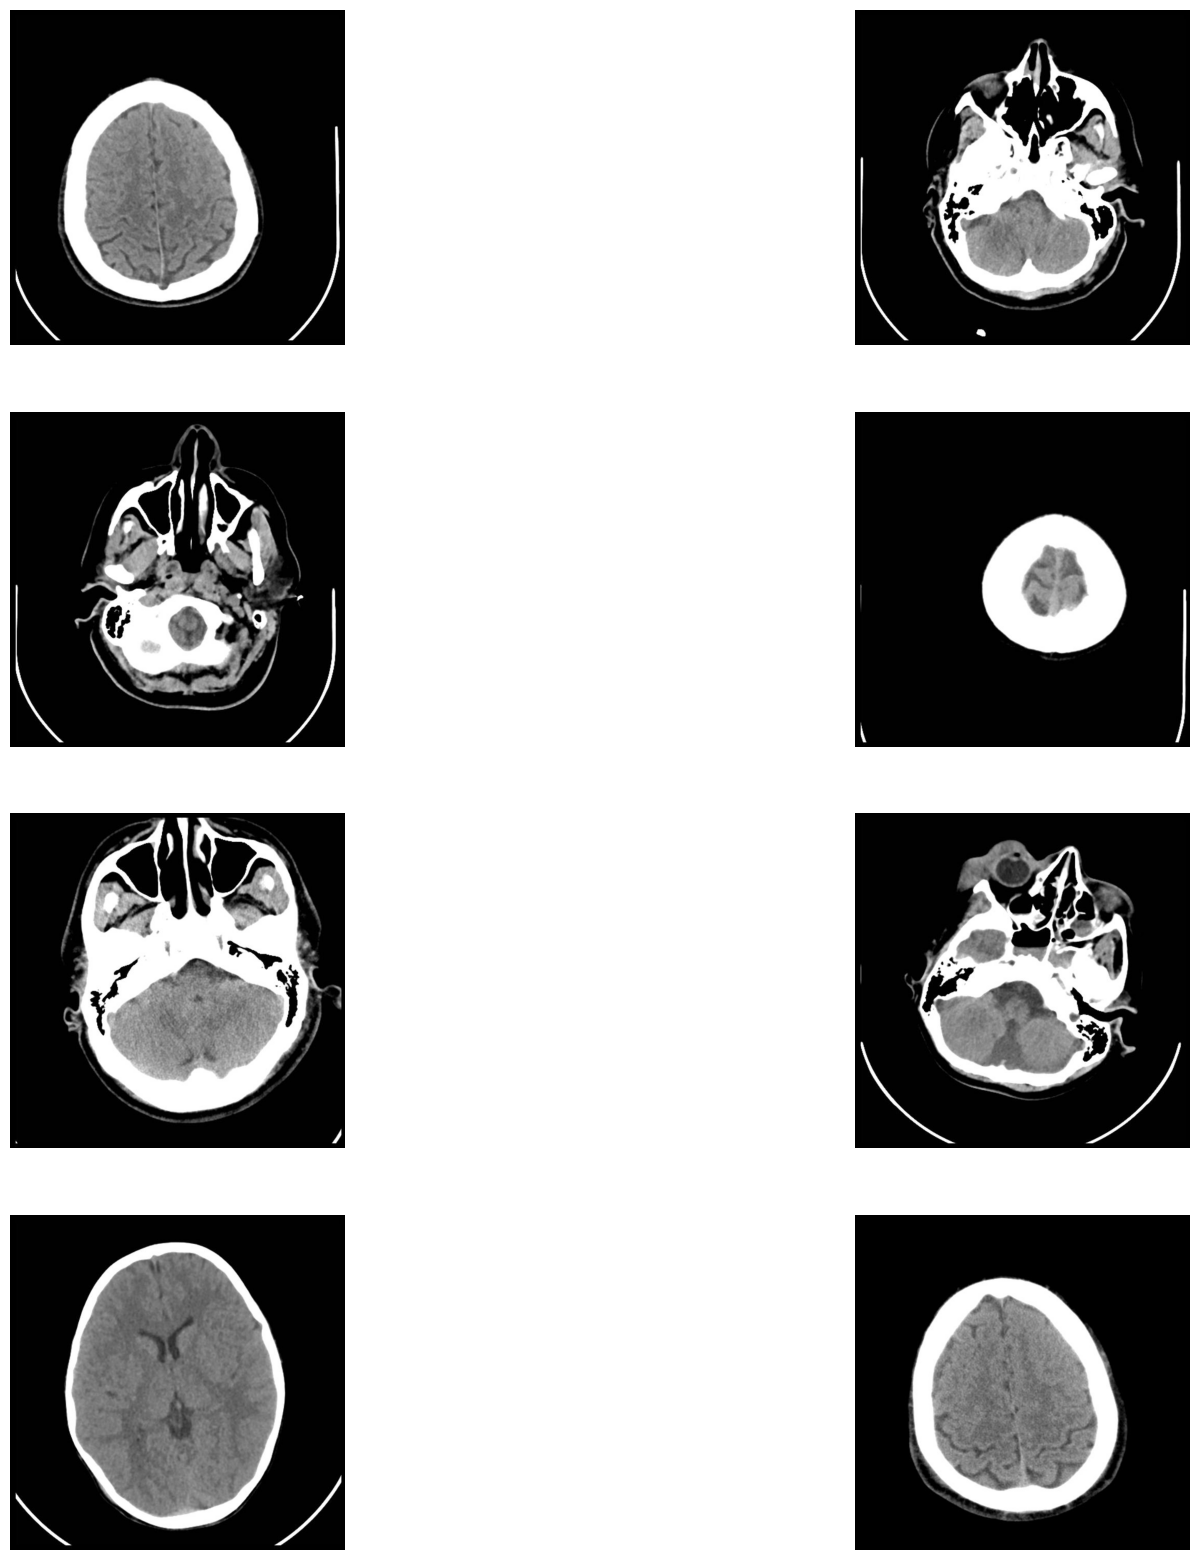

In [ ]:
plotImages2()

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(images,labels_a, train_size=0.8)

In [ ]:
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.2,0.8])  # brightness

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights



58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(1, activation='sigmoid')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)
filepath='/content/drive/MyDrive/Brain_Data_Organised/saved_model.ckpt'
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

#epochs
epochs = 25
# Batch size
batch_size = 32

history = model.fit(train_datagen.flow(X_train,y_train,
                                       batch_size=batch_size, 
                                       seed=27,
                                       shuffle=False),
                    epochs=epochs,
                    callbacks = [es],
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    validation_data=(X_test,y_test),
                    verbose=1)

Epoch 1/25
62/62 [==============================] - 54s 668ms/step - loss: 1.5727 - accuracy: 0.5823 - val_loss: 1.3323 - val_accuracy: 0.6135
Epoch 2/25
62/62 [==============================] - 37s 597ms/step - loss: 0.6952 - accuracy: 0.7022 - val_loss: 0.7487 - val_accuracy: 0.7331
Epoch 3/25
62/62 [==============================] - 36s 572ms/step - loss: 0.6230 - accuracy: 0.7170 - val_loss: 0.7095 - val_accuracy: 0.7291
Epoch 4/25
62/62 [==============================] - 37s 598ms/step - loss: 0.5492 - accuracy: 0.7536 - val_loss: 0.8672 - val_accuracy: 0.7490
Epoch 5/25
62/62 [==============================] - 35s 567ms/step - loss: 0.5073 - accuracy: 0.7785 - val_loss: 0.6557 - val_accuracy: 0.7729
Epoch 6/25
62/62 [==============================] - 37s 593ms/step - loss: 0.4544 - accuracy: 0.7927 - val_loss: 0.5838 - val_accuracy: 0.7610
Epoch 7/25
62/62 [==============================] - 36s 573ms/step - loss: 0.4252 - accuracy: 0.7983 - val_loss: 0.6276 - val_accuracy: 0.7649

In [ ]:
model.save('/content/drive/MyDrive/ModelSaved/mainmodel.h5')

In [ ]:
trial = keras.models.load_model('/content/drive/MyDrive/ModelSaved/mainmodel.h5')

In [ ]:
score = trial.evaluate(X_valid, y_valid, verbose=0)
print("%s: %.2f%%" % (trial.metrics_names[1], score[1]*100))

accuracy: 79.60%


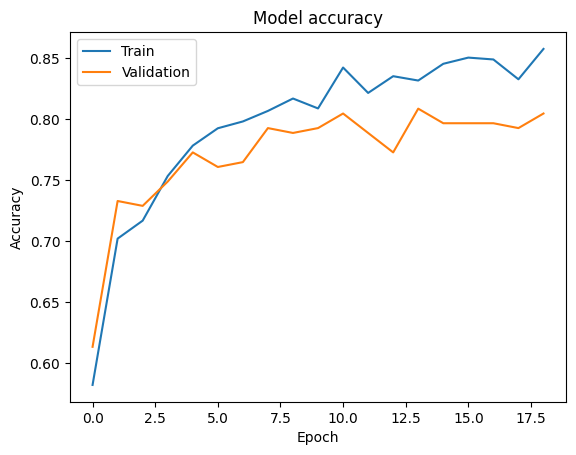

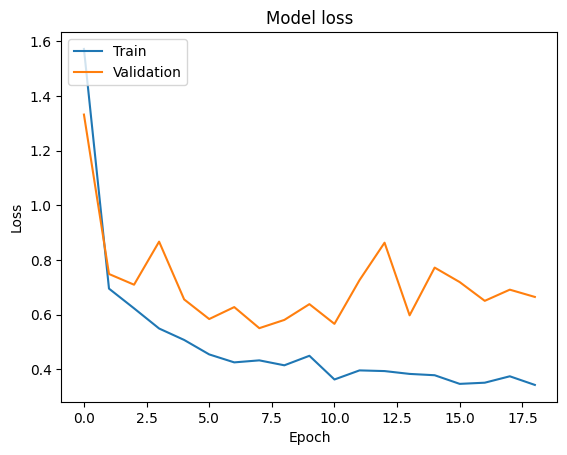

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_valid[int(X_valid.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

8/8 [==============================] - 1s 142ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, preds_test_t, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       158
           1       0.80      0.65      0.71        93

    accuracy                           0.81       251
   macro avg       0.81      0.78      0.79       251
weighted avg       0.81      0.81      0.80       251



In [ ]:
conf = (confusion_matrix(y_test, preds_test_t))

<Axes: >

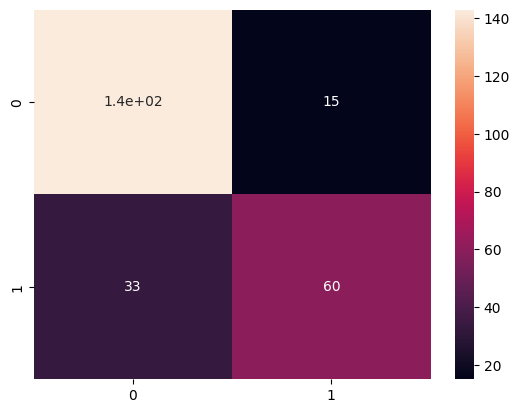

In [ ]:
import seaborn as sns
sns.heatmap(conf, annot=True)

#Inception V3

In [ ]:
import tensorflow as tf

def get_image_datasets(images_path, validation_split=0.2, target_size=(224,224), batch_size=20):
  """Generates the training and validation image datasets"""
  img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255, 
      validation_split=validation_split)

  train_ds = img_generator.flow_from_directory(
      images_path,
      target_size=target_size,
      batch_size=batch_size,
      shuffle=True,
      class_mode='binary',
      subset='training'
  )

  validation_ds = img_generator.flow_from_directory(
      images_path,
      target_size=target_size,
      batch_size=batch_size,
      shuffle=True,
      class_mode='binary',
      subset='validation'
  )

  return train_ds, validation_ds

In [ ]:
def create_model(input_shape=(224, 224, 3), inner_size=100, drop_rate=0.1, learning_rate=0.001):
  """Creates the CNN model based on Transfer Learning"""
  base_model = tf.keras.applications.InceptionV3(input_shape=input_shape,
                                                include_top=False,
                                                weights="imagenet")

  base_model.trainable = False

  model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(inner_size, activation='relu'),
      tf.keras.layers.Dropout(rate=drop_rate),
      tf.keras.layers.Dense(1, activation="sigmoid")
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

  return model

In [ ]:
def train_model(model, model_path, train_ds, validation_ds, steps_per_epoch=20, epochs=20, callbacks=[]):
  """Trains the model"""
  history = model.fit(train_ds, 
                      validation_data=validation_ds, 
                      steps_per_epoch=steps_per_epoch, 
                      epochs=epochs,
                      callbacks=callbacks)
  
  return history, model

In [ ]:
ROOT_PATH = '/content/drive/MyDrive/'
IMAGES_PATH = ROOT_PATH + os.sep + 'Brain_Data_Organised'

In [ ]:
train_ds, validation_ds = get_image_datasets(images_path=IMAGES_PATH)

Found 2001 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
model = create_model()
model.summary()

87910968/87910968 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 22,007,785
Trainable params: 205,001
Non-tr

In [ ]:
scores = {}

for lr in [0.001, 0.01, 0.1]:
  print(lr)

  model = create_model(learning_rate=lr)
  history, model = train_model(model, model_path=ROOT_PATH, train_ds=train_ds, validation_ds=validation_ds)

  scores[lr] = history.history

0.001
Epoch 1/20
20/20 [==============================] - 481s 24s/step - loss: 0.8883 - accuracy: 0.5825 - val_loss: 0.6654 - val_accuracy: 0.6260
Epoch 2/20
20/20 [==============================] - 144s 7s/step - loss: 0.6814 - accuracy: 0.5600 - val_loss: 0.6811 - val_accuracy: 0.6200
Epoch 3/20
20/20 [==============================] - 132s 7s/step - loss: 0.6414 - accuracy: 0.6150 - val_loss: 0.6369 - val_accuracy: 0.6540
Epoch 4/20
20/20 [==============================] - 115s 6s/step - loss: 0.6146 - accuracy: 0.6675 - val_loss: 0.6452 - val_accuracy: 0.6460
Epoch 5/20
20/20 [==============================] - 92s 4s/step - loss: 0.6141 - accuracy: 0.6425 - val_loss: 0.6458 - val_accuracy: 0.6460
Epoch 6/20
20/20 [==============================] - 69s 3s/step - loss: 0.6053 - accuracy: 0.6225 - val_loss: 0.6527 - val_accuracy: 0.6160
Epoch 7/20
20/20 [==============================] - 49s 2s/step - loss: 0.5767 - accuracy: 0.7175 - val_loss: 0.6398 - val_accuracy: 0.6240
Epoch 8/2

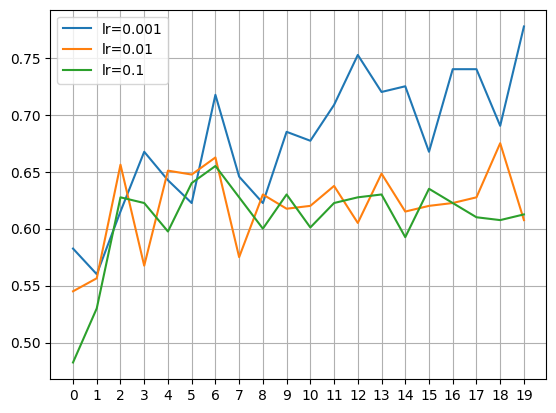

In [ ]:
for lr, history in scores.items():
  plt.plot(history['accuracy'], label=('lr=%s' % lr))

plt.xticks(np.arange(20))
plt.legend()
plt.grid()

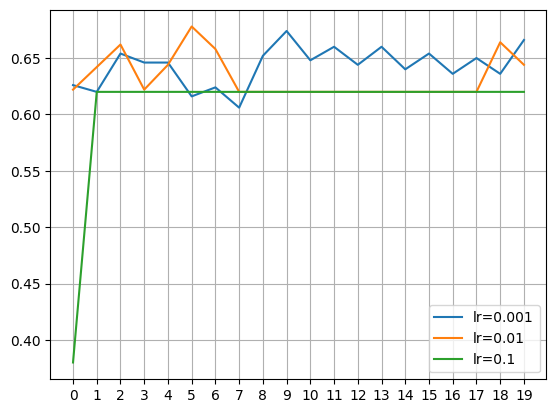

In [ ]:
for lr, history in scores.items():
  plt.plot(history['val_accuracy'], label=('lr=%s' % lr))

plt.xticks(np.arange(20))
plt.legend()
plt.grid()

Best learning rate: 0.001